In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/

/content/drive/MyDrive


In [ ]:
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torch.nn.functional as F
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision
from functools import partial
import pytorch_lightning as pl
from pytorch_lightning.core.datamodule import LightningDataModule
from torch.utils.data import random_split, DataLoader
from matplotlib.patches import Rectangle
import random


In [ ]:
def MultiApply(func, *args, **kwargs):
    pfunc = partial(func, **kwargs) if kwargs else func
    map_results = map(pfunc, *args)
  
    return tuple(map(list, zip(*map_results)))

# This function compute the IOU between two set of boxes 
def IOU(output, target):
    ##################################
    #TODO compute the IOU between the boxA, boxB boxes
    ##################################
  
    output_box_x1 = output[:, 0] - output[:, 2] / 2
    output_box_y1 = output[:, 1] - output[:, 3] / 2
    output_box_x2 = output[:, 0] + output[:, 2] / 2
    output_box_y2 = output[:, 1] + output[:, 3] / 2
    target_box_x1 = target[:, 0] - target[:, 2] / 2
    target_box_y1 = target[:, 1] - target[:, 3] / 2
    target_box_x2 = target[:, 0] + target[:, 2] / 2
    target_box_y2 = target[:, 1] + target[:, 3] / 2

    x1 = torch.max(output_box_x1, target_box_x1)
    y1 = torch.max(output_box_y1, target_box_y1)
    x2 = torch.min(output_box_x2, target_box_x2)
    y2 = torch.min(output_box_y2, target_box_y2)

    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    output_box_area = target[:, 2] * target[:, 3] 
    target_box_area = output[:, 2] * output[:, 3] 

    return intersection / (output_box_area + target_box_area - intersection + 1e-6)


# This function decodes the output of the box head that are given in the [t_x,t_y,t_w,t_h] format
# into box coordinates where it return the upper left and lower right corner of the bbox
# Input:
#       regressed_boxes_t: (total_proposals,4) ([t_x,t_y,t_w,t_h] format)
#       flatten_proposals: (total_proposals,4) ([x1,y1,x2,y2] format)
# Output:
#       box: (total_proposals,4) ([x1,y1,x2,y2] format)
def output_decoding(out,anchors, device='cpu'):
    #######################################
    # TODO decode the output
    #######################################
    anchors = anchors.cpu()
    box = torch.zeros(out.shape)

    box[0,:,:] = out[0,:,:]*anchors[:,:,2] + anchors[:,:,0]
    box[1,:,:] = out[1,:,:]*anchors[:,:,3] + anchors[:,:,1]
    box[2,:,:] = torch.exp(out[2,:,:])*anchors[:,:,2]
    box[3,:,:] = torch.exp(out[3,:,:])*anchors[:,:,3]
    
    return box

def flattened_output_decoding(flatten_out,flatten_anchors, device='cpu'):
    #######################################
    # TODO decode the output
    #######################################
    flatten_anchors = flatten_anchors.cpu()
    box = torch.zeros(flatten_out.shape)
    box[:, 0] = (flatten_out[:, 0] * flatten_anchors[:, 2]) + flatten_anchors[:,0]
    box[:, 1] = (flatten_out[:, 1] * flatten_anchors[:, 3]) + flatten_anchors[:,1]
    box[:, 2] = torch.exp(flatten_out[:, 2]) * flatten_anchors[:, 2]
    box[:, 3] = torch.exp(flatten_out[:, 3]) * flatten_anchors[:, 3]
    
    return box


def pretrained_models_680(checkpoint_file,eval=True):

    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False)

    if(eval):
        model.eval()

    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)

    backbone = model.backbone
    rpn = model.rpn

    if(eval):
        backbone.eval()
        rpn.eval()

    rpn.nms_thresh=0.6
    checkpoint = torch.load(checkpoint_file)

    backbone.load_state_dict(checkpoint['backbone'])
    rpn.load_state_dict(checkpoint['rpn'])

    return backbone, rpn

In [ ]:
def load_data(paths):
  images_file = h5py.File(paths[0],'r') 
  masks_file = h5py.File(paths[1],'r')
  

  images = np.array(images_file['data'])
  masks = np.array(masks_file['data'])
  bboxes = np.load(paths[3], allow_pickle=True)
  labels = np.load(paths[2], allow_pickle=True)

  label_based_masks = []
  cur_pointer = 0
  for label in labels:
    cur_mask = np.empty((len(label), 300, 400))

    for i in range(len(label)):
      cur_mask[i] = masks[cur_pointer]
      cur_pointer += 1
    label_based_masks.append(cur_mask)

  label_based_masks = np.array(label_based_masks)

  return images, label_based_masks, labels, bboxes

def collate_fn(batch):
    images, labels, masks, bounding_boxes, indices = list(zip(*batch))
    return torch.stack(images), labels, masks, bounding_boxes, indices

class BuildDataset(Dataset):
    def __init__(self, path, image_transform=None, mask_transform = None):
        #############################################
        # TODO Initialize  Dataset
        #############################################
        self.images, self.masks, self.labels, self.bboxes = load_data(path)

        self.image_transform = image_transform
        self.mask_transform = mask_transform

    # In this function for given index we rescale the image and the corresponding  masks, boxes
    # and we return them as output
    # output:
        # transed_img
        # label
        # transed_mask
        # transed_bbox
        # index
    def __getitem__(self, idx):
        ################################
        # TODO return transformed images,labels,masks,boxes,index
        ################################
        image = self.images[idx].astype('uint8').transpose(1,2,0)
        label = self.labels[idx].astype('float32')
        mask = torch.tensor(self.masks[idx].astype('float64'))
        bbox = self.bboxes[idx].astype('float32')

        if self.image_transform:
          image = self.image_transform(image)
          mask = self.mask_transform(mask)
          x_scale = 800.0 / 300.0
          y_scale = 1088.0 / 400.0
          for i, box in enumerate(bbox):
            bbox[i][0] = box[0] * x_scale
            bbox[i][1] = box[1] * y_scale
            bbox[i][2] = box[2] * x_scale
            bbox[i][3] = box[3] * y_scale
        
        bbox = torch.tensor(bbox, device = device)

        assert image.shape == (3,800,1088)
        assert bbox.shape[0] == mask.shape[0]
        
        return image, label, mask, bbox, idx

    # This function preprocess the given image, mask, box by rescaling them appropriately
    # output:
    #        img: (3,800,1088)
    #        mask: (n_box,800,1088)
    #        box: (n_box,4)
    # def pre_process_batch(self, img, mask, bbox):
    #     #######################################
    #     # TODO apply the correct transformation to the images,masks,boxes
    #     ######################################

    #     assert img.squeeze(0).shape == (3, 800, 1088)
    #     assert bbox.shape[0] == mask.squeeze(0).shape[0]

    #     return img.squeeze(0), mask.squeeze(0), bbox
    
    def __len__(self):
        return self.labels.shape[0]


class BuildDataLoader(LightningDataModule):
    def __init__(self, dataset, batch_size=32):
        super().__init__()

        self.dataset = dataset
        self.batch_size = batch_size

        return

    def setup(self, stage=None):
        test_split = int(0.2 * len(self.dataset))  # 5% of data to be used as validation set
        val_split = int(0.05 * len(self.dataset))
        self.train_data, self.val_data, self.test_data = random_split(self.dataset, [len(self.dataset)-test_split-val_split, val_split, test_split])

        return
        

    def train_dataloader(self):
        
        # Generating train_dataloader
        return DataLoader(self.train_data, batch_size = self.batch_size, collate_fn=collate_fn, shuffle = True)
    
    def val_dataloader(self):
        
        # Generating train_dataloader
        return DataLoader(self.val_data, batch_size = self.batch_size, collate_fn=collate_fn, shuffle = True)
    
    def predict_dataloader(self):
        
        # Generating val_dataloader
        return DataLoader(self.test_data, batch_size = 1, collate_fn=collate_fn, shuffle = False)


In [ ]:
intermediate_layer = nn.Sequential(
                                    nn.Linear(in_features=256, out_features=1024),
                                    nn.ReLU(),
                                    nn.Linear(in_features=1024, out_features=1024),
                                    nn.ReLU()
                                    )


In [ ]:
#BoxHead.py

class BoxHead(pl.LightningModule):
    def __init__(self,Classes=3,P=7, eval_ = False):
        super(BoxHead,self).__init__()
        self.C=Classes
        self.P=P
        self.train_losses = []
        self.validation_losses = []
        self.eval_ = eval_
        # TODO initialize BoxHead

        self.intermediate_layer = nn.Sequential(
                                    nn.Linear(in_features=256*self.P*self.P, out_features=1024),
                                    nn.ReLU(),
                                    nn.Linear(in_features=1024, out_features=1024),
                                    nn.ReLU()
                                    )

        self.classifier_head = nn.Sequential(
                                  nn.Linear(in_features=1024, out_features=self.C+1)
                                  )
        
        self.regressor_head = nn.Sequential(
                                  nn.Linear(in_features=1024, out_features=4*(self.C))
            
                                  )
        
        for layer in self.intermediate_layer:
          self._init_weights(layer)
        for layer in self.classifier_head:
          self._init_weights(layer)
        for layer in self.regressor_head:
          self._init_weights(layer)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=0.01)
            if module.bias is not None:
                module.bias.data.zero_()

    #  This function assigns to each proposal either a ground truth box or the background class (we assume background class is 0)
    #  Input:
    #       proposals: list:len(bz){(per_image_proposals,4)} ([x1,y1,x2,y2] format)
    #       gt_labels: list:len(bz) {(n_obj)}
    #       bbox: list:len(bz){(n_obj, 4)}
    #  Output: (make sure the ordering of the proposals are consistent with MultiScaleRoiAlign)
    #       labels: (total_proposals,1) (the class that the proposal is assigned)
    #       regressor_target: (total_proposals,4) (target encoded in the [t_x,t_y,t_w,t_h] format)
    def create_ground_truth(self,proposals,gt_labels,bboxes):
      labels = []
      regressor_target = []

      for cur_batch, cur_image_proposals_ in enumerate(proposals):
        cur_image_max_iou = 0
        cur_proposal_label = 0
        cur_image_labels = []
        cur_image_regressor_targets = []

        cur_image_proposals = torch.zeros_like(cur_image_proposals_, device = device)
        cur_image_proposals[:,0] = (cur_image_proposals_[:,0] + cur_image_proposals_[:,2]) / 2
        cur_image_proposals[:,1] = (cur_image_proposals_[:,1] + cur_image_proposals_[:,3]) / 2
        cur_image_proposals[:,2] = cur_image_proposals_[:,2] - cur_image_proposals_[:,0] 
        cur_image_proposals[:,3] = cur_image_proposals_[:,3] - cur_image_proposals_[:,1]

        cur_bbox = torch.zeros_like(bboxes[cur_batch], device = device)
        cur_bbox[:,0] = (bboxes[cur_batch][:,0] + bboxes[cur_batch][:,2]) / 2
        cur_bbox[:,1] = (bboxes[cur_batch][:,1] + bboxes[cur_batch][:,3]) / 2
        cur_bbox[:,2] = bboxes[cur_batch][:,2] - bboxes[cur_batch][:,0] 
        cur_bbox[:,3] = bboxes[cur_batch][:,3] - bboxes[cur_batch][:,1]

        for cur_proposal_ind, cur_proposal in enumerate(cur_image_proposals):
          
          replicated_proposal = cur_proposal.repeat((len(cur_bbox), 1))
          cur_IOU = IOU(cur_bbox.to(device), replicated_proposal.to(device)) # send (x,y,w,h)

          max_iou, max_iou_ind = torch.max(cur_IOU, dim = 0)

          if max_iou > 0.5:
            cur_proposal_label = gt_labels[cur_batch][max_iou_ind]
            
            cur_proposal_bbox = cur_bbox[max_iou_ind]
          else:
            cur_proposal_label = 0
            cur_proposal_bbox = torch.tensor([1,2,3,4], device = device) #TODO

          labels.append(cur_proposal_label)

          box = torch.zeros_like(cur_proposal_bbox)

          box[0] = ((cur_proposal_bbox[0]-cur_proposal[0])/cur_proposal[2])
          box[1] = ((cur_proposal_bbox[1]-cur_proposal[1])/cur_proposal[3])
          box[2] = (torch.log(cur_proposal_bbox[2] / cur_proposal[2]))
          box[3] = (torch.log(cur_proposal_bbox[3] / cur_proposal[3]))

          regressor_target.append(box)

      regressor_target = torch.stack(regressor_target)
      return [int(x) for x in labels], regressor_target



    # This function for each proposal finds the appropriate feature map to sample and using RoIAlign it samples
    # a (256,P,P) feature map. This feature map is then flattened into a (256*P*P) vector
    # Input:
    #      fpn_feat_list: list:len(FPN){(bz,256,H_feat,W_feat)}
    #      proposals: list:len(bz){(per_image_proposals,4)} ([x1,y1,x2,y2] format)
    #      P: scalar
    # Output:
    #      feature_vectors: (total_proposals, 256*P*P)  (make sure the ordering of the proposals are the same as the ground truth creation)
    def MultiScaleRoiAlign(self, fpn_feat_list,proposals,P=7):
        #####################################
        # Here you can use torchvision.ops.RoIAlign check the docs
        #####################################

        image_size = (800, 1088) # (h, w)
        feature_vectors = []

        num_proposals = len(proposals)
        for i in range(num_proposals):
            cur_proposal = proposals[i]
            for j in range(cur_proposal.shape[0]):
              width = cur_proposal[j][2] - cur_proposal[j][0]
              height = cur_proposal[j][3] - cur_proposal[j][1]
              K = torch.clip(torch.floor( 4 + torch.log2(torch.sqrt(width*height)/224)),2,5).int()
          
              box = cur_proposal[j].clone()
              scale_x = image_size[1]/fpn_feat_list[K-2].shape[3]
              scale_y = image_size[0]/fpn_feat_list[K-2].shape[2]

              box = box.reshape(1,-1)
              box[:,0] = box[:,0] / scale_x
              box[:,1] = box[:,1] / scale_y 
              box[:,2] = box[:,2] / scale_x
              box[:,3] = box[:,3] / scale_y
            
              feature_map = fpn_feat_list[K-2][i].unsqueeze(0) 
              aligned_box_map  = torchvision.ops.roi_align(feature_map, [box], output_size=P, spatial_scale=1, sampling_ratio=-1)
              aligned_box_map = aligned_box_map.flatten()

              feature_vectors.append(aligned_box_map)
        
        feature_vectors = torch.stack(feature_vectors, dim=0)

        return feature_vectors


    def training_step(self, batch, batch_idx):
      images, labels, masks, bboxes, indices = batch
      # logits, bbox_regs = self.forward(images.to(device))
      # ground_clas, ground_coord = self.create_batch_truth(bboxes, indices, self.image_size)
      
      images = images.to(device)
      backout = backbone(images)

      # The RPN implementation takes as first argument the following image list
      im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
      # Then we pass the image list and the backbone output through the rpn
      rpnout = rpn(im_lis, backout)
      proposals=[proposal[0:keep_topK,:] for proposal in rpnout[0]]
      # A list of features produces by the backbone's FPN levels: list:len(FPN){(bz,256,H_feat,W_feat)}
      fpn_feat_list= list(backout.values())

      feature_vectors = self.MultiScaleRoiAlign(fpn_feat_list, proposals)

      labels, regressor_targets = model.create_ground_truth(proposals, labels, bboxes)
      # labels, regressor_target = labels[:keep_topK], regressor_target[:keep_topK]
      class_logits, box_preds = self.forward(feature_vectors)

      '''
      proposals: x1
      '''

      labels = torch.tensor(labels)
      loss, loss_c, loss_r = self.compute_loss(class_logits, box_preds, labels, regressor_targets,l=10,effective_batch=150)
      
      self.log("train_class_loss", loss_c, prog_bar=True)
      self.log("train_regr_loss", loss_r, prog_bar=True)
      self.log("train_loss", loss, prog_bar=True)

      return {"loss": loss, "loss_c": loss_c, "loss_r": loss_r}
    
    
    def training_epoch_end(self, outputs):
      self.train_losses.append((torch.tensor([output["loss"] for output in outputs]).mean().item(),\
                                torch.tensor([output["loss_c"] for output in outputs]).mean().item(), \
                                torch.tensor([output["loss_r"] for output in outputs]).mean().item()))

    def validation_step(self, batch, batch_idx):
      images, labels, masks, bboxes, indices = batch
      
      images = images.to(device)
      backout = backbone(images)

      # The RPN implementation takes as first argument the following image list
      im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
      # Then we pass the image list and the backbone output through the rpn
      rpnout = rpn(im_lis, backout)
      proposals=[proposal[0:keep_topK,:] for proposal in rpnout[0]]
      # A list of features produces by the backbone's FPN levels: list:len(FPN){(bz,256,H_feat,W_feat)}
      fpn_feat_list= list(backout.values())

      feature_vectors = self.MultiScaleRoiAlign(fpn_feat_list, proposals)

      labels, regressor_targets = model.create_ground_truth(proposals, labels, bboxes)
      # labels, regressor_target = labels[:keep_topK], regressor_target[:keep_topK]
      class_logits, box_preds = self.forward(feature_vectors)

      '''
      proposals: x1
      '''

      labels = torch.tensor(labels)
      loss, loss_c, loss_r = self.compute_loss(class_logits, box_preds, labels, regressor_targets,l=10,effective_batch=150)
      
      self.log("val_class_loss", loss_c, prog_bar=True)
      self.log("val_regr_loss", loss_r, prog_bar=True)
      self.log("val_loss", loss, prog_bar=True)

      return {"loss": loss, "loss_c": loss_c, "loss_r": loss_r}
    
    def validation_epoch_end(self, outputs):
      self.validation_losses.append((torch.tensor([output["loss"] for output in outputs]).mean().item(),\
                                torch.tensor([output["loss_c"] for output in outputs]).mean().item(), \
                                torch.tensor([output["loss_r"] for output in outputs]).mean().item()))
    
    def configure_optimizers(self):
      optimizer = torch.optim.SGD(self.parameters(), lr=0.001, weight_decay = 5e-4)
      scheduler = {"scheduler": torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 30], gamma=0.1)}
      return {"optimizer": optimizer, 'lr_scheduler': scheduler}


    # This function does the post processing for the results of the Box Head for a batch of images
    # Use the proposals to distinguish the outputs from each image
    # Input:
    #       class_logits: (total_proposals,(C+1))
    #       box_regression: (total_proposal,4*C)           ([t_x,t_y,t_w,t_h] format)
    #       proposals: list:len(bz)(per_image_proposals,4) (the proposals are produced from RPN [x1,y1,x2,y2] format)
    #       conf_thresh: scalar
    #       keep_num_preNMS: scalar (number of boxes to keep pre NMS)
    #       keep_num_postNMS: scalar (number of boxes to keep post NMS)
    # Output:
    #       boxes: list:len(bz){(post_NMS_boxes_per_image,4)}  ([x1,y1,x2,y2] format)
    #       scores: list:len(bz){(post_NMS_boxes_per_image)}   ( the score for the top class for the regressed box)
    #       labels: list:len(bz){(post_NMS_boxes_per_image)}   (top class of each regressed box)
    def postprocess_detections(self, decoded_image, class_logits, box_regression, proposals, conf_thresh=0.5, keep_num_preNMS=500, keep_num_postNMS=50, plot_ = True):

      class_scores, class_labels = torch.max(class_logits, dim =1)
      valid_indices = class_labels > 0
      
      proposals = proposals[valid_indices]
      box_regression = box_regression[valid_indices]
      class_labels = class_labels[valid_indices]
      class_scores = class_scores[valid_indices]
      

      boxes = torch.zeros((len(class_labels), 4))
      for i in range(len(class_labels)):
        boxes[i,:] = box_regression[i, (class_labels[i]-1)*4:class_labels[i]*4 ]
      boxes = flattened_output_decoding(boxes, proposals)

      boxes[boxes[:,2] > 1088, 2] = 1088
      boxes[boxes[:,3] > 800, 3] = 800
      boxes[boxes[:,0] < 0, 0] = 0
      boxes[boxes[:,1] < 0, 1] = 0

      sorted_scores, sorted_indices = torch.sort(class_scores, descending = True) 

      keep_num_preNMS = min(keep_num_preNMS, len(sorted_scores))
      pre_nms_indices = sorted_indices[0:keep_num_preNMS]
      pre_nms_scores = sorted_scores[0:keep_num_preNMS] 
      boxes = boxes[pre_nms_indices,:]
      class_labels = class_labels[pre_nms_indices]

      
      boxes = boxes.detach().numpy()

      if plot_:
        label_to_color = {}
        label_to_color[1] = 'r'
        label_to_color[2] = 'g'
        label_to_color[3] = 'b'
        gt_label_color = 'c'

        label_to_class = {1: 'Vehicle', 2: 'Person', 3: 'Animal'}
        label_to_color_name = {1: 'Red', 2: 'Green', 3: 'Blue'}
        if keep_num_postNMS > 0:
          print('------------------- Predicted Boxes pre-NMS ----------------')
          
        figure, axis = plt.subplots(1, 3)
        figure.set_size_inches(18.5, 10.5)

        axis[0].imshow(decoded_image.permute(1, 2, 0))
        axis[0].set_title('Cyan = Ground Truth Box, ' + label_to_color_name[1] + ' = ' +label_to_class[1] + ' box.') 
        axis[1].imshow(decoded_image.permute(1, 2, 0))
        axis[1].set_title('Cyan = Ground Truth Box, ' + label_to_color_name[2] + ' = ' +label_to_class[2] + ' box.') 
        axis[2].imshow(decoded_image.permute(1, 2, 0))
        axis[2].set_title('Cyan = Ground Truth Box, ' + label_to_color_name[3] + ' = ' +label_to_class[3] + ' box.') 
        
        proposals = boxes
        for i, label in enumerate(class_labels):
            
            # proposal box
            proposal = proposals[i, :]
            box = Rectangle((proposal[0], proposal[1]), proposal[2] - proposal[0], proposal[3] - proposal[1],  linewidth=1, edgecolor=label_to_color[label.item()], facecolor='none')
            axis[int(label) - 1].add_patch(box)

        plt.show()



      if keep_num_postNMS > 0:
        if pre_nms_scores.shape[0] == 0:
          return None, None, None
        print('------------------- Predicted Boxes post-NMS ----------------')
        post_nms_score, post_nms_boxes, post_nms_labels  = self.NMS(pre_nms_scores, torch.tensor(boxes, device = device), torch.tensor(class_labels, device= device), conf_thresh)
        sorted_post_nms_scores, sorted_post_nms_indices = torch.sort(post_nms_score, descending = True) 

        keep_num_postNMS = min(keep_num_postNMS, len(post_nms_score))
  
        post_nms_indices = sorted_post_nms_indices[0:keep_num_postNMS]
        post_nms_scores = sorted_post_nms_scores[0:keep_num_postNMS]
        
        post_nms_boxes = post_nms_boxes[post_nms_indices,:]
        post_nms_labels = post_nms_labels[post_nms_indices]
        
        if plot_:
          boxes = post_nms_boxes.cpu().numpy()
          
          figure, axis = plt.subplots(1, 3)
          figure.set_size_inches(18.5, 10.5)

          axis[0].imshow(decoded_image.permute(1, 2, 0))
          axis[0].set_title('Cyan = Ground Truth Box, ' + label_to_color_name[1] + ' = ' +label_to_class[1] + ' box.') 
          axis[1].imshow(decoded_image.permute(1, 2, 0))
          axis[1].set_title('Cyan = Ground Truth Box, ' + label_to_color_name[2] + ' = ' +label_to_class[2] + ' box.') 
          axis[2].imshow(decoded_image.permute(1, 2, 0))
          axis[2].set_title('Cyan = Ground Truth Box, ' + label_to_color_name[3] + ' = ' +label_to_class[3] + ' box.') 
          
          proposals = boxes
     
          for i, label in enumerate(post_nms_labels):
 
            if label != 0:
              
              # proposal box
              proposal = proposals[i, :]
    
              box = Rectangle((proposal[0], proposal[1]), proposal[2] - proposal[0], proposal[3] - proposal[1],  linewidth=1, edgecolor=label_to_color[label.item()], facecolor='none')
              axis[int(label) - 1].add_patch(box)

          plt.show()
          print('\n')
     

        return post_nms_scores, post_nms_boxes, post_nms_labels
      else:
        return 0,0,0


    # Compute the loss of the classifier
    # Input:
    #      p_out:     (positives_on_mini_batch)  (output of the classifier for sampled anchors with positive gt labels)
    #      n_out:     (negatives_on_mini_batch) (output of the classifier for sampled anchors with negative gt labels
    def loss_class(self,p_out,n_out,p_label, n_label):


        # TODO compute classifier's loss
        
        target = torch.cat((p_label,n_label), 0).to(device)
        output = torch.cat((p_out, n_out), 0)
      

        loss_classifier = torch.nn.CrossEntropyLoss()
        loss = loss_classifier(output, target)

        return loss

    # Compute the loss of the regressor
    # Input:
    #       pos_target_coord: (positive_on_mini_batch,4) (ground truth of the regressor for sampled anchors with positive gt labels)
    #       pos_out_r: (positive_on_mini_batch,4)        (output of the regressor for sampled anchors with positive gt labels)
    def loss_reg(self,pos_target_coord,pos_out_r):
            #torch.nn.SmoothL1Loss()
            # TODO compute regressor's loss
         
            loss_regressor = torch.nn.SmoothL1Loss(reduction = 'sum')
            loss = loss_regressor(pos_out_r,pos_target_coord)

            return loss

    # Compute the total loss of the classifier and the regressor
    # Input:
    #      class_logits: (total_proposals,(C+1)) (as outputed from forward, not passed from softmax so we can use CrossEntropyLoss)
    #      box_preds: (total_proposals,4*C)      (as outputed from forward)
    #      labels: (total_proposals,1)
    #      regression_targets: (total_proposals,4)
    #      l: scalar (weighting of the two losses)
    #      effective_batch: scalar
    # Outpus:
    #      loss: scalar
    #      loss_class: scalar
    #      loss_regr: scalar
    def compute_loss(self,class_logits, box_preds, labels, regression_targets,l=1,effective_batch=150):
    
        

        pos_n = (labels != 0).sum().item()
        neg_n = labels.shape[0] - pos_n


        if pos_n < (3*effective_batch/4):
          pos_idx = np.random.choice(pos_n, pos_n, replace = False)
          neg_idx = np.random.choice(neg_n, min(effective_batch - pos_n, neg_n), replace = False) 
          if(effective_batch - pos_n > neg_n):
            print('!!!ALERT!!! \n effective_batch - pos_n:', effective_batch - pos_n, ' neg_n:', neg_n, ' labels.shape[0]:', labels.shape[0])
        else:
          pos_idx = np.random.choice(pos_n, (3*effective_batch)//4, replace = False)
          neg_idx = np.random.choice(neg_n, min(effective_batch//4, neg_n), replace = False)
          if(effective_batch//4 > neg_n):
            print('!!!ALERT!!! \n effective_batch//4:', effective_batch//4, ' neg_n:', neg_n, ' labels.shape[0]:', labels.shape[0])

        p_out = class_logits[(labels != 0), :][pos_idx, :]
    
        n_out = class_logits[(labels == 0), :][neg_idx, :]
        p_label = labels[ (labels != 0)][pos_idx]
        n_label = labels[ (labels == 0)][neg_idx]
        loss_c = self.loss_class(p_out, n_out, p_label, n_label)


        regr_pos = box_preds[(labels != 0) ,:][pos_idx,:]
        rows = np.arange(regr_pos.shape[0]).reshape(-1,1)

        box_pred = regr_pos[rows,:4]

        targ_regr_pos = regression_targets[(labels != 0) ,:][pos_idx,:]
        loss_r = self.loss_reg(targ_regr_pos, box_pred.squeeze(0))/effective_batch

        loss = loss_c + l*loss_r
        
        return loss, loss_c, loss_r



    # Forward the pooled feature vectors through the intermediate layer and the classifier, regressor of the box head
    # Input:
    #        feature_vectors: (total_proposals, 256*P*P)
    # Outputs:
    #        class_logits: (total_proposals,(C+1)) (we assume classes are C classes plus background, notice if you want to use
    #                                               CrossEntropyLoss you should not pass the output through softmax here)
    #        box_pred:     (total_proposals,4*C)
    def forward(self, feature_vectors):
      
      X = self.intermediate_layer(feature_vectors)

      class_logits = self.classifier_head(X)

      if self.eval_:
        softmax = nn.Softmax()
        class_logits = softmax(class_logits)

      box_pred = self.regressor_head(X)

      return class_logits, box_pred

    def NMS(self,clas,prebox, labels, thresh):
    ##################################
    # TODO perform NSM
    ##################################
    
      method= 'gauss'
      n = len(clas)
      gauss_sigma = 0.5

      x1 = prebox[:,0] - (prebox[:,2]/2).reshape(-1,1)
      y1 = prebox[:,1] - (prebox[:,3]/2).reshape(-1,1)
      x2 = prebox[:,0] + (prebox[:,2]/2).reshape(-1,1)
      y2 = prebox[:,1] + (prebox[:,3]/2).reshape(-1,1)

      x1_ = torch.max(x1,x1.T)
      y1_ = torch.max(y1,y1.T)
      x2_ = torch.min(x2,x2.T)
      y2_ = torch.min(y2,y2.T)

      intersection = (x2_ - x1_ + 1).clamp(0) * (y2_ - y1_ + 1).clamp(0)

      union = (x2 - x1 + 1) * (y2 - y1 + 1) + (x2.T - x1.T + 1) * (y2.T - y1.T + 1) - intersection

      ious = (intersection / union).triu(diagonal=1)

      ious_cmax = ious.max(0)[0].expand(n, n).T
      if method == 'gauss':
          decay = torch.exp(-(ious ** 2 - ious_cmax ** 2) / gauss_sigma)
      else:
          decay = (1 - ious) / (1 - ious_cmax)
      decay  = decay.min(dim=0)[0]

      decay_clas = clas*decay

      sorted_decay_score, sorted_decay_idx = torch.sort(decay_clas,descending = True)
      
      nms_prebox = prebox[sorted_decay_idx,:]
      nms_clas = sorted_decay_score
    
      nms_labels = labels[sorted_decay_idx]


      return nms_clas, nms_prebox, nms_labels




In [ ]:
# Put the path were you save the given pretrained model
pretrained_path='/content/drive/MyDrive/Pretrained_Models/checkpoint680.pth'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
backbone, rpn = pretrained_models_680(pretrained_path)
backbone = backbone.to(device).eval()
rpn = rpn.to(device).eval()

# we will need the ImageList from torchvision
from torchvision.models.detection.image_list import ImageList


imgs_path = '/content/drive/MyDrive/data_rusk/hw3_mycocodata_img_comp_zlib.h5'
masks_path = '/content/drive/MyDrive/data_rusk/hw3_mycocodata_mask_comp_zlib.h5'
labels_path = '/content/drive/MyDrive/data_rusk/hw3_mycocodata_labels_comp_zlib.npy'
bboxes_path = '/content/drive/MyDrive/data_rusk/hw3_mycocodata_bboxes_comp_zlib.npy'

paths = [imgs_path, masks_path, labels_path, bboxes_path]

batch_size = 16
num_epochs = 36

image_transform = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Resize((800, 1066)),
                            transforms.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
                            transforms.Pad([11,0])
                            ])

mask_transform = transforms.Compose([       
                          transforms.Resize((800, 1066)),
                          transforms.Pad([11,0])
                          ])

COCOdata = BuildDataset(paths, image_transform, mask_transform)

COCODataLoader = BuildDataLoader(COCOdata, batch_size=batch_size)

COCODataLoader.setup()
test_loader = COCODataLoader.predict_dataloader() 

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


###Training Faster-RCNN model

In [ ]:
model = BoxHead(Classes=3,P=7)
model.to(device)
keep_topK=20
trainer = pl.Trainer(max_epochs=num_epochs, gpus=1, num_sanity_val_steps=0)
trainer.fit(model, COCODataLoader)
torch.save(model.state_dict(), 'boxhead.pth')
np.save('train_losses.npy', model.train_losses)
np.save('val_losses.npy', model.validation_losses)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type       | Params
--------------------------------------------------
0 | intermediate_layer | Sequential | 13.9 M
1 | classifier_head    | Sequential | 4.1 K 
2 | reg

Training: 0it [00:00, ?it/s]

!!!ALERT!!! 
 effective_batch - pos_n: 143  neg_n: 13  labels.shape[0]: 20


Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/data.py:86: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 16. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  "Trying to infer the `batch_size` from an ambiguous collection. The batch size we"


!!!ALERT!!! 
 effective_batch - pos_n: 139  neg_n: 49  labels.shape[0]: 60


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/data.py:86: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  "Trying to infer the `batch_size` from an ambiguous collection. The batch size we"


!!!ALERT!!! 
 effective_batch - pos_n: 137  neg_n: 7  labels.shape[0]: 20


Validation: 0it [00:00, ?it/s]

!!!ALERT!!! 
 effective_batch - pos_n: 131  neg_n: 41  labels.shape[0]: 60
!!!ALERT!!! 
 effective_batch - pos_n: 145  neg_n: 15  labels.shape[0]: 20


Validation: 0it [00:00, ?it/s]

!!!ALERT!!! 
 effective_batch - pos_n: 130  neg_n: 40  labels.shape[0]: 60
!!!ALERT!!! 
 effective_batch - pos_n: 142  neg_n: 12  labels.shape[0]: 20


Validation: 0it [00:00, ?it/s]

!!!ALERT!!! 
 effective_batch - pos_n: 134  neg_n: 44  labels.shape[0]: 60
!!!ALERT!!! 
 effective_batch - pos_n: 145  neg_n: 15  labels.shape[0]: 20


Validation: 0it [00:00, ?it/s]

!!!ALERT!!! 
 effective_batch - pos_n: 132  neg_n: 42  labels.shape[0]: 60
!!!ALERT!!! 
 effective_batch - pos_n: 140  neg_n: 10  labels.shape[0]: 20


Validation: 0it [00:00, ?it/s]

!!!ALERT!!! 
 effective_batch - pos_n: 137  neg_n: 47  labels.shape[0]: 60
!!!ALERT!!! 
 effective_batch - pos_n: 143  neg_n: 13  labels.shape[0]: 20


Validation: 0it [00:00, ?it/s]

!!!ALERT!!! 
 effective_batch - pos_n: 130  neg_n: 40  labels.shape[0]: 60
!!!ALERT!!! 
 effective_batch - pos_n: 146  neg_n: 16  labels.shape[0]: 20


Validation: 0it [00:00, ?it/s]

!!!ALERT!!! 
 effective_batch - pos_n: 134  neg_n: 44  labels.shape[0]: 60
!!!ALERT!!! 
 effective_batch - pos_n: 143  neg_n: 13  labels.shape[0]: 20


Validation: 0it [00:00, ?it/s]

!!!ALERT!!! 
 effective_batch - pos_n: 138  neg_n: 48  labels.shape[0]: 60
!!!ALERT!!! 
 effective_batch - pos_n: 143  neg_n: 13  labels.shape[0]: 20


Validation: 0it [00:00, ?it/s]

!!!ALERT!!! 
 effective_batch - pos_n: 138  neg_n: 48  labels.shape[0]: 60
!!!ALERT!!! 
 effective_batch - pos_n: 147  neg_n: 17  labels.shape[0]: 20


Validation: 0it [00:00, ?it/s]

!!!ALERT!!! 
 effective_batch - pos_n: 134  neg_n: 44  labels.shape[0]: 60
!!!ALERT!!! 
 effective_batch - pos_n: 143  neg_n: 13  labels.shape[0]: 20


Validation: 0it [00:00, ?it/s]

!!!ALERT!!! 
 effective_batch - pos_n: 133  neg_n: 43  labels.shape[0]: 60
!!!ALERT!!! 
 effective_batch - pos_n: 145  neg_n: 15  labels.shape[0]: 20


Validation: 0it [00:00, ?it/s]

!!!ALERT!!! 
 effective_batch - pos_n: 137  neg_n: 47  labels.shape[0]: 60
!!!ALERT!!! 
 effective_batch - pos_n: 142  neg_n: 12  labels.shape[0]: 20


Validation: 0it [00:00, ?it/s]

!!!ALERT!!! 
 effective_batch - pos_n: 133  neg_n: 43  labels.shape[0]: 60
!!!ALERT!!! 
 effective_batch - pos_n: 147  neg_n: 17  labels.shape[0]: 20


Validation: 0it [00:00, ?it/s]

!!!ALERT!!! 
 effective_batch - pos_n: 128  neg_n: 38  labels.shape[0]: 60
!!!ALERT!!! 
 effective_batch - pos_n: 143  neg_n: 13  labels.shape[0]: 20


Validation: 0it [00:00, ?it/s]

!!!ALERT!!! 
 effective_batch - pos_n: 134  neg_n: 44  labels.shape[0]: 60
!!!ALERT!!! 
 effective_batch - pos_n: 145  neg_n: 15  labels.shape[0]: 20


Validation: 0it [00:00, ?it/s]

!!!ALERT!!! 
 effective_batch - pos_n: 134  neg_n: 44  labels.shape[0]: 60
!!!ALERT!!! 
 effective_batch - pos_n: 143  neg_n: 13  labels.shape[0]: 20


Validation: 0it [00:00, ?it/s]

!!!ALERT!!! 
 effective_batch - pos_n: 138  neg_n: 48  labels.shape[0]: 60
!!!ALERT!!! 
 effective_batch - pos_n: 140  neg_n: 10  labels.shape[0]: 20


Validation: 0it [00:00, ?it/s]

!!!ALERT!!! 
 effective_batch - pos_n: 134  neg_n: 44  labels.shape[0]: 60
!!!ALERT!!! 
 effective_batch - pos_n: 147  neg_n: 17  labels.shape[0]: 20


Validation: 0it [00:00, ?it/s]

!!!ALERT!!! 
 effective_batch - pos_n: 137  neg_n: 47  labels.shape[0]: 60
!!!ALERT!!! 
 effective_batch - pos_n: 143  neg_n: 13  labels.shape[0]: 20


Validation: 0it [00:00, ?it/s]

!!!ALERT!!! 
 effective_batch - pos_n: 135  neg_n: 45  labels.shape[0]: 60
!!!ALERT!!! 
 effective_batch - pos_n: 144  neg_n: 14  labels.shape[0]: 20


Validation: 0it [00:00, ?it/s]

!!!ALERT!!! 
 effective_batch - pos_n: 136  neg_n: 46  labels.shape[0]: 60
!!!ALERT!!! 
 effective_batch - pos_n: 147  neg_n: 17  labels.shape[0]: 20


Validation: 0it [00:00, ?it/s]

!!!ALERT!!! 
 effective_batch - pos_n: 131  neg_n: 41  labels.shape[0]: 60
!!!ALERT!!! 
 effective_batch - pos_n: 145  neg_n: 15  labels.shape[0]: 20


Validation: 0it [00:00, ?it/s]

!!!ALERT!!! 
 effective_batch - pos_n: 127  neg_n: 37  labels.shape[0]: 60
!!!ALERT!!! 
 effective_batch - pos_n: 147  neg_n: 17  labels.shape[0]: 20


Validation: 0it [00:00, ?it/s]

!!!ALERT!!! 
 effective_batch - pos_n: 131  neg_n: 41  labels.shape[0]: 60
!!!ALERT!!! 
 effective_batch - pos_n: 147  neg_n: 17  labels.shape[0]: 20


Validation: 0it [00:00, ?it/s]

!!!ALERT!!! 
 effective_batch - pos_n: 130  neg_n: 40  labels.shape[0]: 60
!!!ALERT!!! 
 effective_batch - pos_n: 140  neg_n: 10  labels.shape[0]: 20


Validation: 0it [00:00, ?it/s]

!!!ALERT!!! 
 effective_batch - pos_n: 135  neg_n: 45  labels.shape[0]: 60
!!!ALERT!!! 
 effective_batch - pos_n: 150  neg_n: 20  labels.shape[0]: 20


Validation: 0it [00:00, ?it/s]

!!!ALERT!!! 
 effective_batch - pos_n: 127  neg_n: 37  labels.shape[0]: 60
!!!ALERT!!! 
 effective_batch - pos_n: 146  neg_n: 16  labels.shape[0]: 20


Validation: 0it [00:00, ?it/s]

!!!ALERT!!! 
 effective_batch - pos_n: 134  neg_n: 44  labels.shape[0]: 60
!!!ALERT!!! 
 effective_batch - pos_n: 144  neg_n: 14  labels.shape[0]: 20


Validation: 0it [00:00, ?it/s]

!!!ALERT!!! 
 effective_batch - pos_n: 136  neg_n: 46  labels.shape[0]: 60
!!!ALERT!!! 
 effective_batch - pos_n: 144  neg_n: 14  labels.shape[0]: 20


Validation: 0it [00:00, ?it/s]

!!!ALERT!!! 
 effective_batch - pos_n: 136  neg_n: 46  labels.shape[0]: 60
!!!ALERT!!! 
 effective_batch - pos_n: 148  neg_n: 18  labels.shape[0]: 20


Validation: 0it [00:00, ?it/s]

!!!ALERT!!! 
 effective_batch - pos_n: 133  neg_n: 43  labels.shape[0]: 60
!!!ALERT!!! 
 effective_batch - pos_n: 149  neg_n: 19  labels.shape[0]: 20


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:922: UserWarning: Using a target size (torch.Size([1, 4])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


Validation: 0it [00:00, ?it/s]

!!!ALERT!!! 
 effective_batch - pos_n: 137  neg_n: 47  labels.shape[0]: 60
!!!ALERT!!! 
 effective_batch - pos_n: 145  neg_n: 15  labels.shape[0]: 20


Validation: 0it [00:00, ?it/s]

!!!ALERT!!! 
 effective_batch - pos_n: 129  neg_n: 39  labels.shape[0]: 60
!!!ALERT!!! 
 effective_batch - pos_n: 147  neg_n: 17  labels.shape[0]: 20


Validation: 0it [00:00, ?it/s]

!!!ALERT!!! 
 effective_batch - pos_n: 136  neg_n: 46  labels.shape[0]: 60
!!!ALERT!!! 
 effective_batch - pos_n: 145  neg_n: 15  labels.shape[0]: 20


Validation: 0it [00:00, ?it/s]

!!!ALERT!!! 
 effective_batch - pos_n: 135  neg_n: 45  labels.shape[0]: 60


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=36` reached.


AttributeError: ignored

###6.1 Image plots that showcase the proposals with the no-background classes and their ground truth boxes.

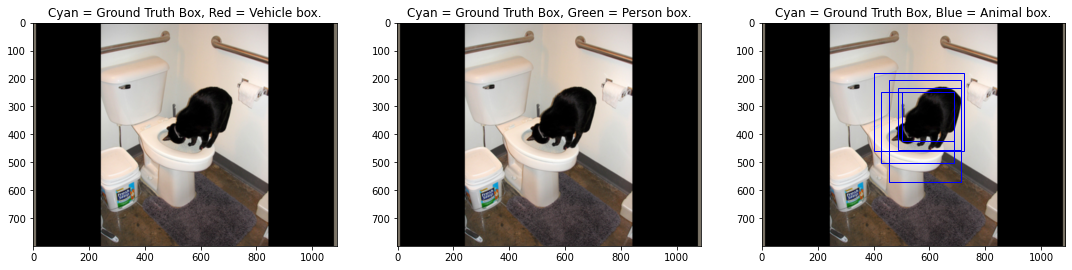

------------------------------------------------------------------------------------------------------


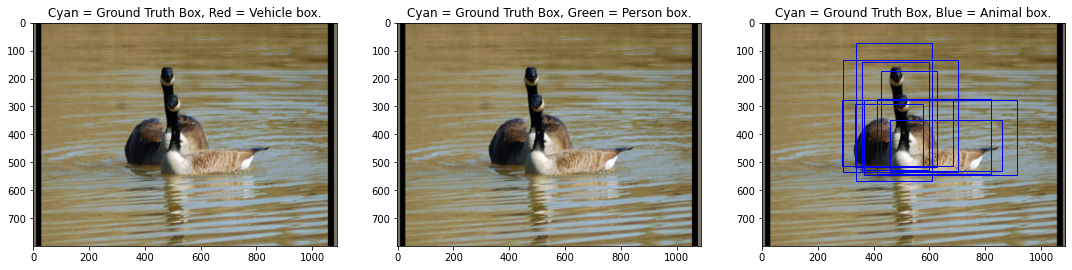

------------------------------------------------------------------------------------------------------


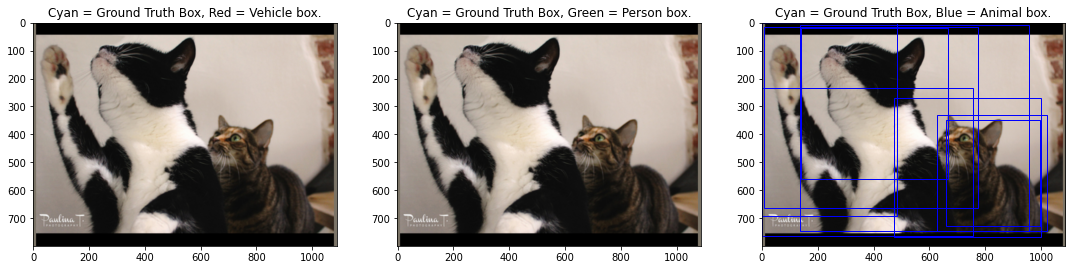

------------------------------------------------------------------------------------------------------


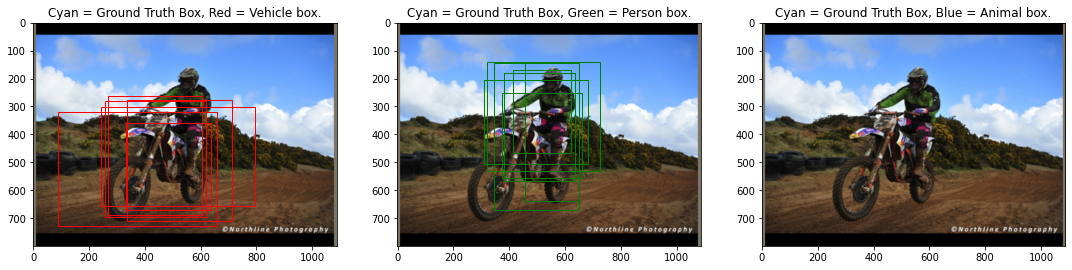

------------------------------------------------------------------------------------------------------


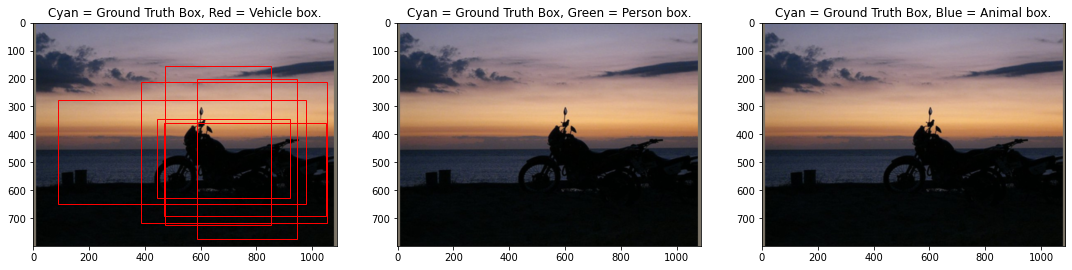

------------------------------------------------------------------------------------------------------


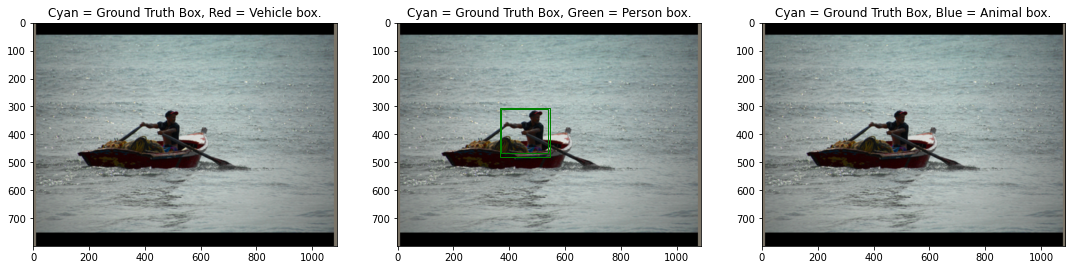

------------------------------------------------------------------------------------------------------


In [ ]:
import random
image_size = (800, 1088)
keep_topK = 20
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = BoxHead(Classes=3,P=7)

for j, idx in enumerate([0, 1, 3, 5, 10, 25]):
  images, labels, masks, bboxes, indices = COCOdata.__getitem__(idx)

  # Take the features from the backbone
  backbone = backbone.to(device)
  images = images.to(device).unsqueeze(0)
  backout = backbone(images)

  # The RPN implementation takes as first argument the following image list
  im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
  # Then we pass the image list and the backbone output through the rpn
  rpnout = rpn(im_lis, backout)
  proposals=[proposal[0:keep_topK,:] for proposal in rpnout[0]]
  
  MEAN = torch.tensor([0.485, 0.456, 0.406])
  STD = torch.tensor([0.229, 0.224, 0.225])

  images = images.cpu().squeeze()

  decoded_image = images * STD[:, None, None] + MEAN[:, None, None]

  labels, regressor_target = model.create_ground_truth(proposals, np.expand_dims(labels, axis = 0), bboxes.unsqueeze(0))
  labels, regressor_target = labels[:keep_topK], regressor_target[:keep_topK].detach()
  
  label_to_color = {}
  label_to_color[1] = 'r'
  label_to_color[2] = 'g'
  label_to_color[3] = 'b'
  gt_label_color = 'c'

  label_to_class = {1: 'Vehicle', 2: 'Person', 3: 'Animal'}
  label_to_color_name = {1: 'Red', 2: 'Green', 3: 'Blue'}
  prev_label = 0

  figure, axis = plt.subplots(1, 3)
  figure.set_size_inches(18.5, 10.5)

  axis[0].imshow(decoded_image.permute(1, 2, 0))
  axis[0].set_title('Cyan = Ground Truth Box, ' + label_to_color_name[1] + ' = ' +label_to_class[1] + ' box.') 
  axis[1].imshow(decoded_image.permute(1, 2, 0))
  axis[1].set_title('Cyan = Ground Truth Box, ' + label_to_color_name[2] + ' = ' +label_to_class[2] + ' box.') 
  axis[2].imshow(decoded_image.permute(1, 2, 0))
  axis[2].set_title('Cyan = Ground Truth Box, ' + label_to_color_name[3] + ' = ' +label_to_class[3] + ' box.') 
  
  for i, label in enumerate(labels):
    if label != 0:
      # groundtruth box 
      groundtruth_box = regressor_target[i, :].cpu()
      w = groundtruth_box[2]
      h = groundtruth_box[3]
      box = Rectangle((groundtruth_box[0]-(w/2), groundtruth_box[1]-(h/2)), w, h, edgecolor=gt_label_color, facecolor=None, fill=False)
      axis[int(label) - 1].add_patch(box)
      
      # proposal box
      proposal = proposals[0][i, :].cpu()
      box = Rectangle((proposal[0], proposal[1]), proposal[2] - proposal[0], proposal[3] - proposal[1],  linewidth=1, edgecolor=label_to_color[label], facecolor='none')
      axis[int(label) - 1].add_patch(box)
  
  plt.show()
  print('------------------------------------------------------------------------------------------------------')


      
      
  

###6.4 Training and Validation curves that show the total loss, the loss of the classifier and the loss of the regressor of the Box Head.

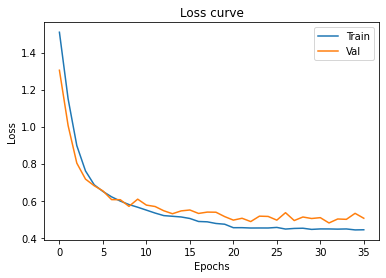

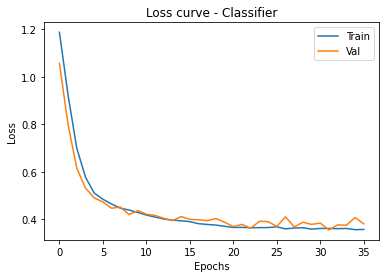

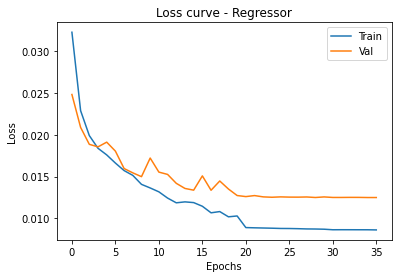

In [315]:
import matplotlib.pyplot as plt

train_losses = np.load("train_losses.npy")
validation_losses = np.load("val_losses.npy")

plt.figure()
epochs = np.arange(36)
plt.plot(epochs, [loss[0] for loss in train_losses], label = 'Train')
plt.plot(epochs, [loss[0] for loss in validation_losses], label = 'Val')
plt.title('Loss curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, [loss[1] for loss in train_losses], label = 'Train')
plt.plot(epochs, [loss[1] for loss in validation_losses], label = 'Val')
plt.title('Loss curve - Classifier')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, [loss[2] for loss in train_losses], label = 'Train')
plt.plot(epochs, [loss[2] for loss in validation_losses], label = 'Val')
plt.title('Loss curve - Regressor')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
 

###6.4 Image plots that contain the top 20 boxes produced by the Box Head for some images of the test set

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:535: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


-------------------------------- TOP 20 proposals -------------------------------


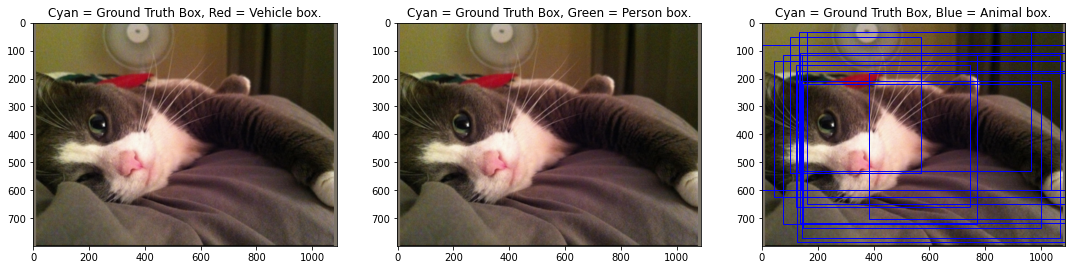



-------------------------------- TOP 20 proposals -------------------------------


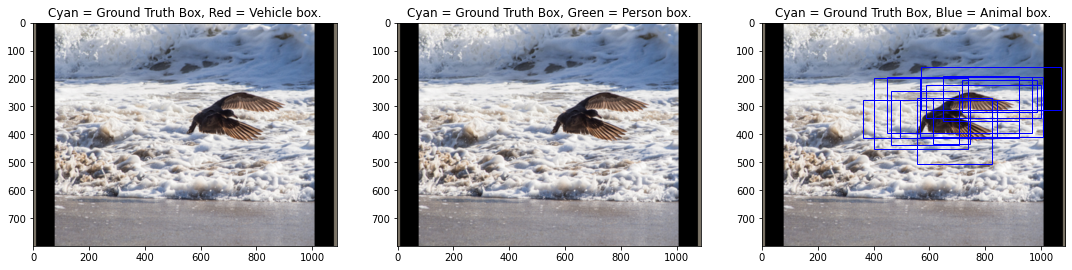



-------------------------------- TOP 20 proposals -------------------------------


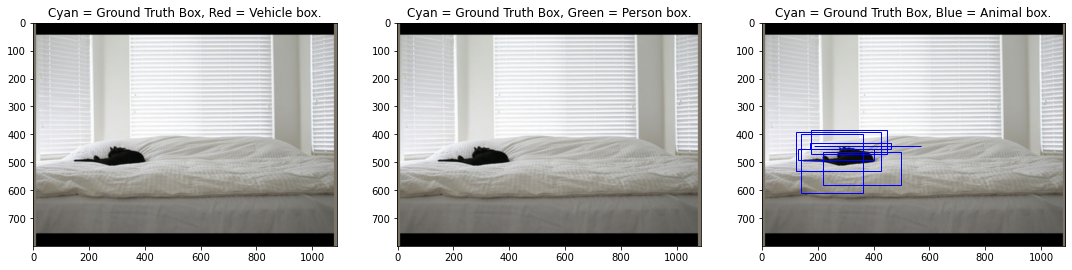



-------------------------------- TOP 20 proposals -------------------------------


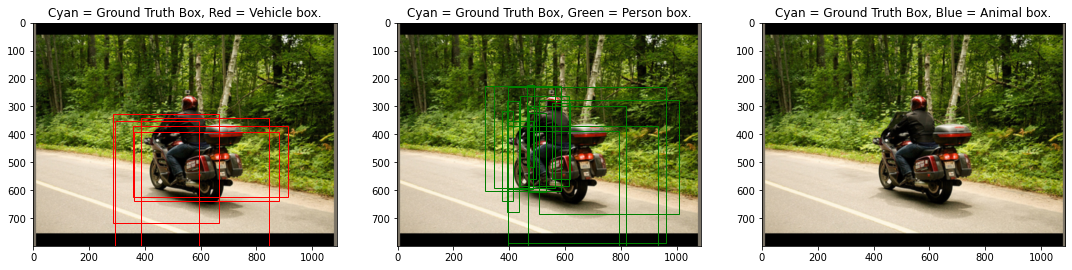



-------------------------------- TOP 20 proposals -------------------------------


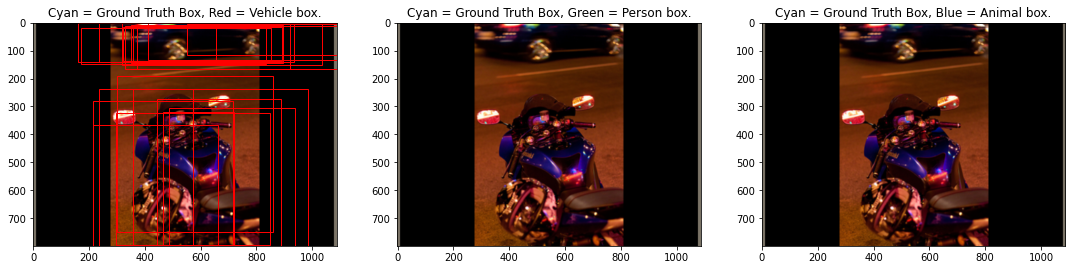



-------------------------------- TOP 20 proposals -------------------------------


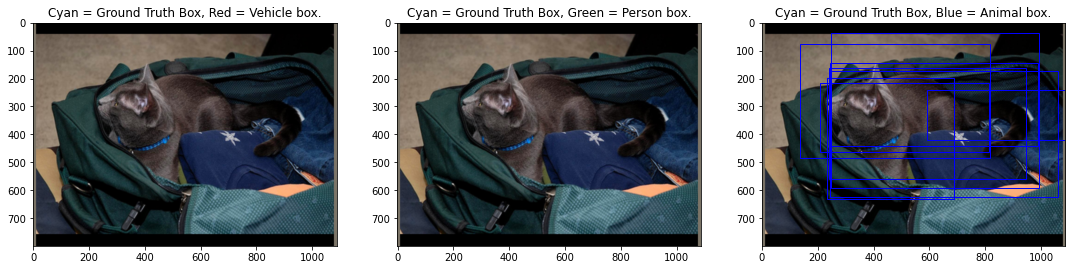

In [321]:
model = BoxHead(Classes=3,P=7, eval_ = True)
model_path = '/content/drive/MyDrive/boxhead.pth'
model.load_state_dict(torch.load(model_path))
model.to(device) 
model.eval()

image_size = (800, 1088)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for j, batch in enumerate(test_loader):
  if j==6:
    break
  images, labels, masks, bboxes, indices = batch

  images = images.to(device)
  backout = backbone(images)

  # The RPN implementation takes as first argument the following image list
  im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
  # Then we pass the image list and the backbone output through the rpn
  rpnout = rpn(im_lis, backout)
  proposals=[proposal[0:keep_topK,:] for proposal in rpnout[0]]
  # A list of features produces by the backbone's FPN levels: list:len(FPN){(bz,256,H_feat,W_feat)}
  fpn_feat_list= list(backout.values())

  feature_vectors = model.MultiScaleRoiAlign(fpn_feat_list, proposals)

  labels, regressor_targets = model.create_ground_truth(proposals, labels, bboxes)
  
  class_logits, box_preds = model.forward(feature_vectors)

  MEAN = torch.tensor([0.485, 0.456, 0.406])
  STD = torch.tensor([0.229, 0.224, 0.225])

  images = images.cpu().squeeze()

  x = images * STD[:, None, None] + MEAN[:, None, None]

  
  print('-------------------------------- TOP 20 proposals -------------------------------')
  model.postprocess_detections(x, class_logits, box_preds, proposals[0], conf_thresh=0.5, keep_num_preNMS=20, keep_num_postNMS=0)
  print('\n')
  




###6.5 Report of the APs and the mAP. 

In [313]:
from collections import defaultdict

model = BoxHead(Classes=3,P=7, eval_ = True)
model_path = '/content/drive/MyDrive/boxhead.pth'
model.load_state_dict(torch.load(model_path))
model.to(device) 
model.eval()

def precision_recall_curve(predictions, targets, target_class):
   true_pos = []
   false_pos = []
   conf = []
   total_gts = 0
 
   N = len(predictions)
 
   for i in range(N):
       pred_bboxes = sorted(predictions[i][target_class],reverse=True)
       num_pred_bboxes = len(pred_bboxes)
       gt_bboxes = targets[i][target_class]
       num_gt_bboxes = len(gt_bboxes)
       total_gts += num_gt_bboxes
      
       # If there are no predicted bounding boxes for the particular class in the image, continue to the next image
       if num_pred_bboxes == 0:
           continue
      
       assigned_gt_bboxes = set()
 
       for j, pred_bbox in enumerate(pred_bboxes):
           conf.append(pred_bbox[0])
           # If there are no ground truths of the particular class in the image, the prediction is a false positive
           if num_gt_bboxes == 0:
               true_pos.append(0)
               false_pos.append(1)
               continue
          
           pred_bbox_ious = []
 
           for k, gt_bbox in enumerate(gt_bboxes): 
                          
               iou = IOU(torch.tensor(pred_bbox[1:]).unsqueeze(0), torch.tensor(gt_bbox).unsqueeze(0))
               pred_bbox_ious.append(iou)
 
          
           pred_bbox_ious = np.array(pred_bbox_ious)
           candidate_gt_bbox = np.argmax(pred_bbox_ious)
 
           if pred_bbox_ious[candidate_gt_bbox] < 0.5 or candidate_gt_bbox in assigned_gt_bboxes:
               true_pos.append(0)
               false_pos.append(1)
           else:
               true_pos.append(1)
               false_pos.append(0)
               assigned_gt_bboxes.add(candidate_gt_bbox)
  
   if total_gts == 0:
       return [], []
  
   conf = np.array(conf)
   order = np.argsort(conf)[::-1]
   true_pos = np.array(true_pos)[order]
   false_pos = np.array(false_pos)[order]
  
   cum_true_pos = true_pos.cumsum()
   cum_false_pos = false_pos.cumsum()
  
   precision =  cum_true_pos / (cum_true_pos + cum_false_pos)
   recall = cum_true_pos / total_gts
   return recall, precision
 
def average_precision(predictions, targets, target_class):
   recall, precision = precision_recall_curve(predictions, targets, target_class)
   precision = np.maximum.accumulate(precision[::-1])[::-1]
 
   average_precision = 0
   n = len(precision)
   for i in range(1, n):
       average_precision += precision[i] * (recall[i] - recall[i - 1])
 
   return average_precision
 
def mean_average_precision(predictions_list, targets_list):
  avg_precision = []



  predictions_dict_list= []
  targets_dict_list = []
  for i,prediction in enumerate(predictions_list):
    predictions_dict = defaultdict(list)
    for bboxs in prediction:
      for bbox in bboxs:
        # print(bbox)
        if bbox[0] == 1:
          predictions_dict['1'].append(bbox[1:])
        if bbox[0] ==2:
          predictions_dict['2'].append(bbox[1:])
        if bbox[0] == 3:
          predictions_dict['3'].append(bbox[1:])
    predictions_dict_list.append(predictions_dict)

  for i,target in enumerate(targets_list):
    targets_dict = defaultdict(list)
    for bboxs in target:
      for bbox in bboxs:
        if bbox[0] == 1:
          targets_dict['1'].append(bbox[1:])
        if bbox[0] ==2:
          targets_dict['2'].append(bbox[1:])
        if bbox[0] == 3:
          targets_dict['3'].append(bbox[1:])
    targets_dict_list.append(targets_dict)

  for cls in ['1', '2', '3']:

    avg_precision_class = average_precision(predictions_dict_list, targets_dict_list, cls)
    avg_precision.append(avg_precision_class)
  mean_average_precision = np.mean(avg_precision)
  return round(mean_average_precision*100,2), avg_precision
 


predictions = []
targets = []

keep_topK = 200

for batch in test_loader:

  img_batch, label_batch, _, bbox_batch, _ = batch
  img_batch = img_batch.to(device)
  # Take the features from the backbone
  backout = backbone(img_batch.float())
  # The RPN implementation takes as first argument the following image list
  im_lis = ImageList(img_batch.float(), [(800, 1088)]*img_batch.shape[0])
  # Then we pass the image list and the backbone output through the rpn
  rpnout = rpn(im_lis, backout)

  #The final output is
  # A list of proposal tensors: list:len(bz){(keep_topK,4)}
  proposals=[proposal[0:keep_topK,:] for proposal in rpnout[0]]
  
  # A list of features produces by the backbone's FPN levels: list:len(FPN){(bz,256,H_feat,W_feat)}
  fpn_feat_list= list(backout.values())
  feature_vectors = model.MultiScaleRoiAlign(fpn_feat_list, proposals)
  class_logits, box_pred = model.forward(feature_vectors)
  scores, boxes, labels = model.postprocess_detections(img_batch.squeeze(0), class_logits = class_logits, box_regression = box_pred, proposals = proposals[0], conf_thresh = 0.8, keep_num_preNMS=50, keep_num_postNMS=5, plot_ = False)

  if scores is None:
    continue
  prediction = []
  for i in range(1):
    prediction.append([np.array([labels[i].detach().cpu().numpy(), scores[i].detach().cpu().numpy(), boxes[i][0].detach().cpu().numpy(), boxes[i][1].detach().cpu().numpy(), boxes[i][2].detach().cpu().numpy(), boxes[i][3].detach().cpu().numpy()])])
  prediction = np.array(prediction)
 
  tgt = [np.concatenate([np.expand_dims(label_batch[0], axis=1), bbox_batch[0].cpu()], axis=1)]
  predictions.append(prediction)
  targets.append(tgt)
 
map, aps = mean_average_precision(predictions, targets)
print('\n')
print('-------------------------------------------')
print("Validation mAP: " + str(map))
print("Validation Vehicle AP: " + str(aps[0]))
print("Validation Person AP: " + str(aps[1]))
print("Validation Animal AP: " + str(aps[2]))
print('-------------------------------------------')
print('\n')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:535: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:354: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).




-------------------------------------------
Validation mAP: 77.7
Validation Vehicle AP: 0.6128772583029592
Validation Person AP: 0.8440473722764994
Validation Animal AP: 0.8741136499327581
-------------------------------------------




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


###6.5 Image plots of the regressed boxes after the postprocessing.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:535: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


------------------- Predicted Boxes pre-NMS ----------------


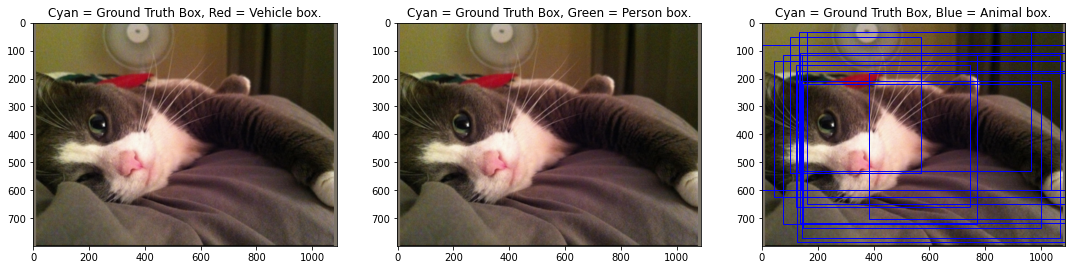

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:354: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


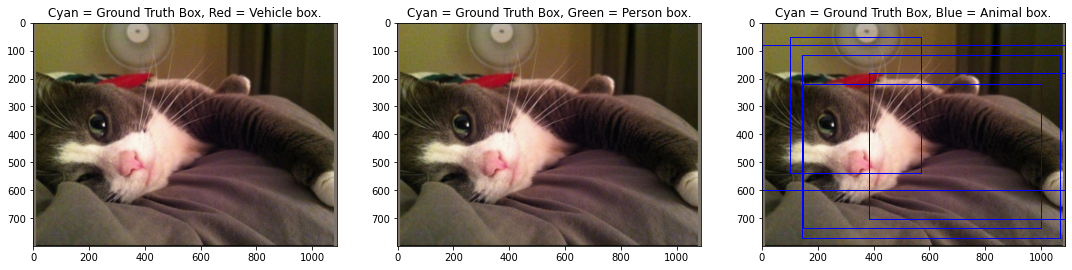





------------------- Predicted Boxes pre-NMS ----------------


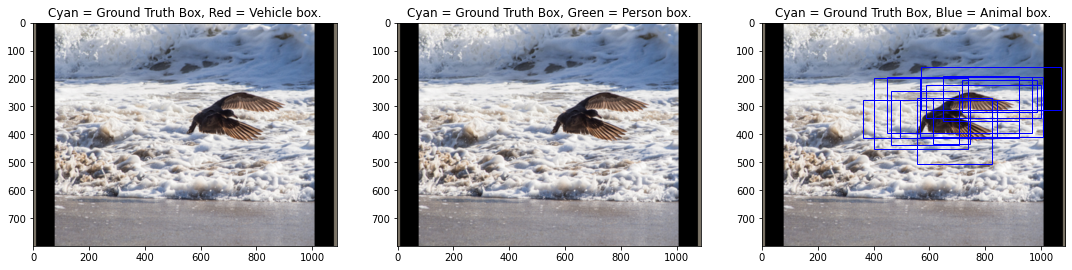

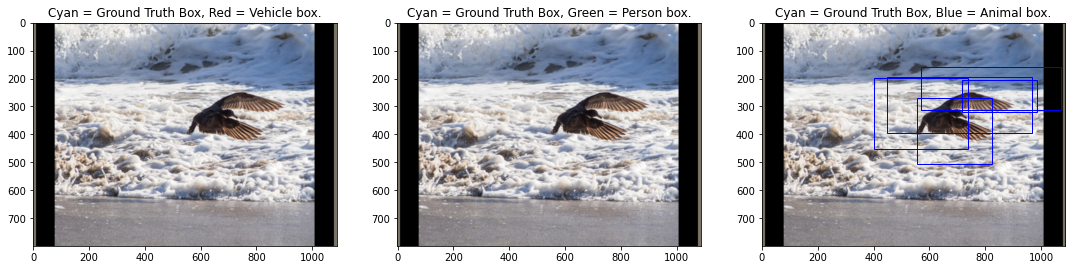





------------------- Predicted Boxes pre-NMS ----------------


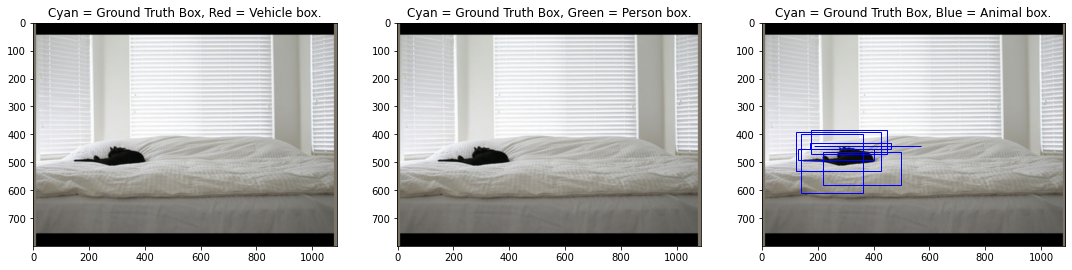

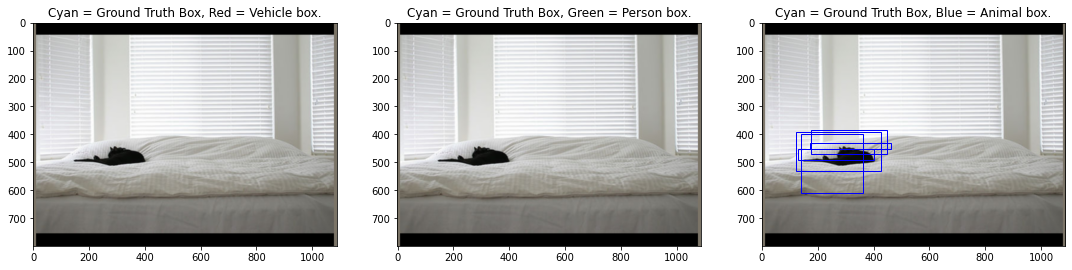





------------------- Predicted Boxes pre-NMS ----------------


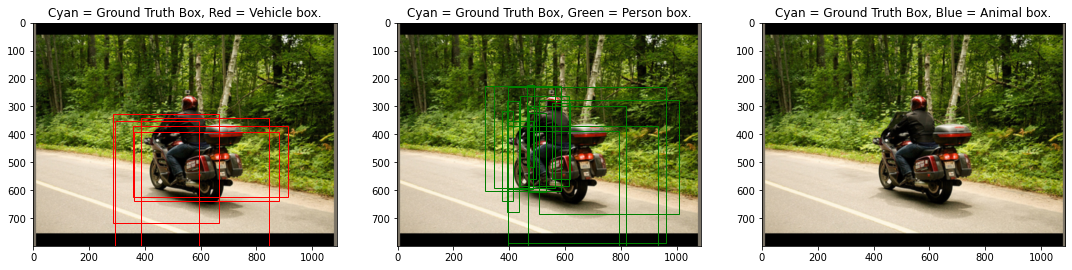

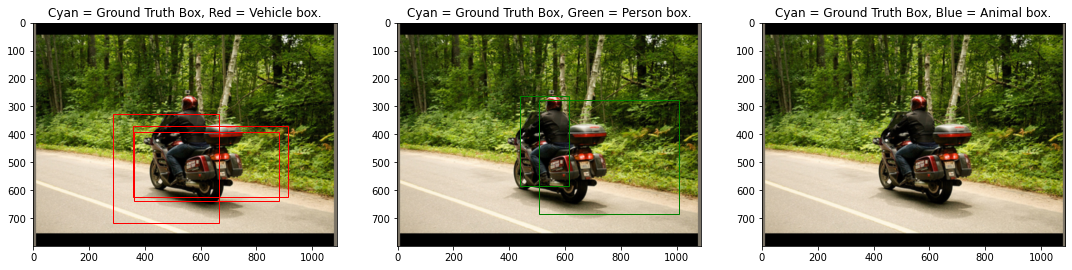





------------------- Predicted Boxes pre-NMS ----------------


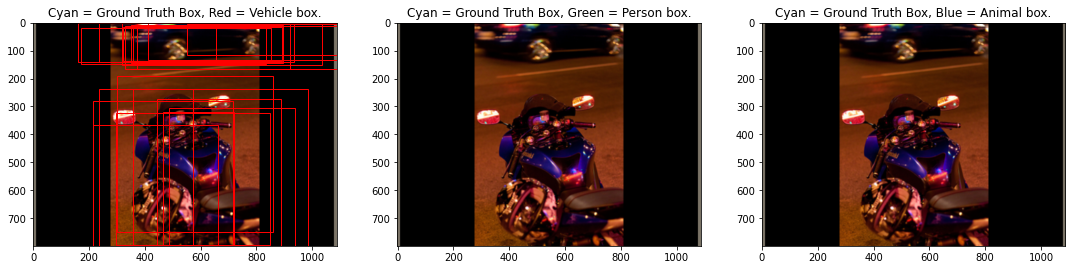

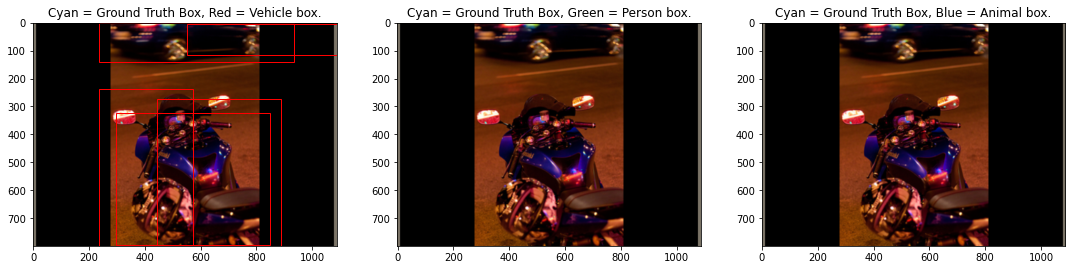





------------------- Predicted Boxes pre-NMS ----------------


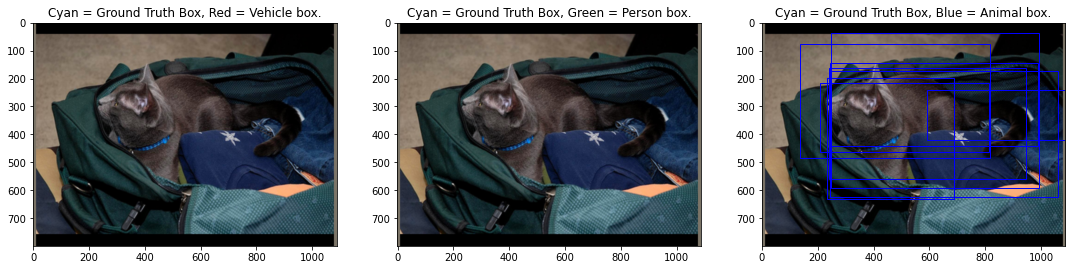

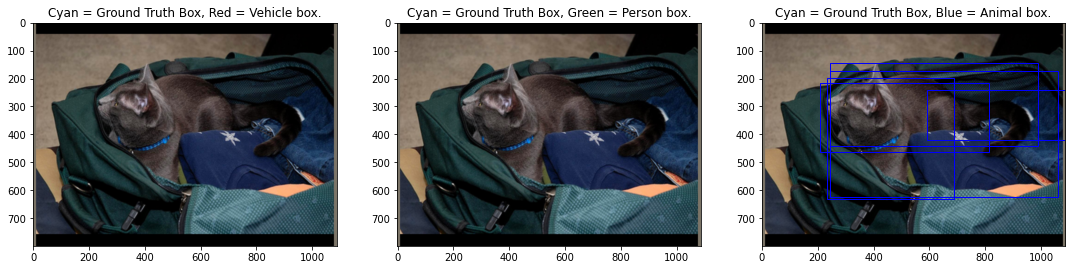

In [319]:
model = BoxHead(Classes=3,P=7, eval_ = True)
model_path = '/content/drive/MyDrive/boxhead.pth'
model.load_state_dict(torch.load(model_path))
model.to(device) 
model.eval()

image_size = (800, 1088)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for j, batch in enumerate(test_loader):
  if j == 6:
    break
  images, labels, masks, bboxes, indices = batch

  images = images.to(device)
  backout = backbone(images)

  # The RPN implementation takes as first argument the following image list
  im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
  # Then we pass the image list and the backbone output through the rpn
  rpnout = rpn(im_lis, backout)
  proposals=[proposal[0:keep_topK,:] for proposal in rpnout[0]]
  # A list of features produces by the backbone's FPN levels: list:len(FPN){(bz,256,H_feat,W_feat)}
  fpn_feat_list= list(backout.values())

  feature_vectors = model.MultiScaleRoiAlign(fpn_feat_list, proposals)

  labels, regressor_targets = model.create_ground_truth(proposals, labels, bboxes)

  class_logits, box_preds = model.forward(feature_vectors)

  MEAN = torch.tensor([0.485, 0.456, 0.406])
  STD = torch.tensor([0.229, 0.224, 0.225])

  images = images.cpu().squeeze()

  x = images * STD[:, None, None] + MEAN[:, None, None]

  
  model.postprocess_detections(x, class_logits, box_preds, proposals[0], conf_thresh=0.5, keep_num_preNMS=20, keep_num_postNMS=5)
  print('\n')      
 




###Performance on hold-out images

In [ ]:
# Put the path were you save the given pretrained model
pretrained_path='/content/drive/MyDrive/Pretrained_Models/checkpoint680.pth'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
backbone, rpn = pretrained_models_680(pretrained_path)

# we will need the ImageList from torchvision
from torchvision.models.detection.image_list import ImageList

# Put the path were the given hold_out_images.npz file is save and load the images
hold_images_path='/content/hold_out_images.npz'
test_images=np.load(hold_images_path,allow_pickle=True)['input_images']


# Load your model here. If you use different parameters for the initialization you can change the following code
# accordingly
model = BoxHead(Classes=3,P=7, eval_ = True)
model_path = '/content/drive/MyDrive/boxhead.pth'
model.load_state_dict(torch.load(model_path))
model.to(device) 
model.eval()

keep_topK=200

cpu_boxes = []
cpu_scores = []
cpu_labels = []

for i, numpy_image in enumerate(test_images, 0):
    images = torch.from_numpy(numpy_image).to(device)
    with torch.no_grad():
        # Take the features from the backbone
        backout = backbone(images)

        # The RPN implementation takes as first argument the following image list
        im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
        # Then we pass the image list and the backbone output through the rpn
        rpnout = rpn(im_lis, backout)

        #The final output is
        # A list of proposal tensors: list:len(bz){(keep_topK,4)}
        proposals=[proposal[0:keep_topK,:] for proposal in rpnout[0]]
        # A list of features produces by the backbone's FPN levels: list:len(FPN){(bz,256,H_feat,W_feat)}
        fpn_feat_list= list(backout.values())


        feature_vectors=model.MultiScaleRoiAlign(fpn_feat_list,proposals)

        class_logits,box_pred=model(feature_vectors)
      

        # Do whaterver post processing you find performs best
        scores,boxes,labels=model.postprocess_detections(images,class_logits,box_pred,proposals[0],conf_thresh=0.5, keep_num_preNMS=200, keep_num_postNMS=3, plot_= False)
       
        if scores is None:
          cpu_boxes.append(None)
          cpu_scores.append(None)
          cpu_labels.append(None)
        else:
          for box, score, label in zip(boxes,scores,labels):
              if box is None:
                  cpu_boxes.append(None)
                  cpu_scores.append(None)
                  cpu_labels.append(None)
              else:
                  cpu_boxes.append(box.to('cpu').detach().numpy())
                  cpu_scores.append(score.to('cpu').detach().numpy())
                  cpu_labels.append(label.to('cpu').detach().numpy())

np.savez('predictions.npz', predictions={'boxes': cpu_boxes, 'scores': cpu_scores,'labels': cpu_labels})


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:533: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:354: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torc

torch.Size([1, 3, 800, 1088])
torch.Size([200, 4])
torch.Size([200, 12])
torch.Size([1, 3, 800, 1088])
torch.Size([200, 4])
torch.Size([200, 12])
torch.Size([1, 3, 800, 1088])
torch.Size([200, 4])
torch.Size([200, 12])
torch.Size([1, 3, 800, 1088])
torch.Size([200, 4])
torch.Size([200, 12])
torch.Size([1, 3, 800, 1088])
torch.Size([200, 4])
torch.Size([200, 12])
torch.Size([1, 3, 800, 1088])
torch.Size([200, 4])
torch.Size([200, 12])
torch.Size([1, 3, 800, 1088])
torch.Size([200, 4])
torch.Size([200, 12])
torch.Size([1, 3, 800, 1088])
torch.Size([200, 4])
torch.Size([200, 12])
torch.Size([1, 3, 800, 1088])
torch.Size([200, 4])
torch.Size([200, 12])
torch.Size([1, 3, 800, 1088])
torch.Size([200, 4])
torch.Size([200, 12])
torch.Size([1, 3, 800, 1088])
torch.Size([200, 4])
torch.Size([200, 12])
torch.Size([1, 3, 800, 1088])
torch.Size([200, 4])
torch.Size([200, 12])
torch.Size([1, 3, 800, 1088])
torch.Size([200, 4])
torch.Size([200, 12])
torch.Size([1, 3, 800, 1088])
torch.Size([200, 4])
